## Imports

In [1]:
!pip install --quiet albumentations pytorch-lightning
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import albumentations as A
from skimage import io
import numpy as np
from PIL import Image
import cv2
import os
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import pandas as pd
from albumentations.pytorch import ToTensorV2
from skimage.io import imread
from typing import Optional
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 931.6/931.6 kB 24.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
import requests
import zipfile
import io


os.mkdir('tests')
url = 'https://www.dropbox.com/scl/fi/q70ca7ld0c78lsecrxm3s/public_tests.zip?rlkey=clp8winkmhaysflwp8y9fdbqe&st=67grolcc&dl=1'

response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall('./tests')

print(os.listdir('./tests'))

['00_test_img_gt', '00_test_img_input']


## Raw data explore

In [4]:
from collections import Counter

In [15]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

In [17]:
gt = read_csv('tests/00_test_img_input/train/gt.csv')
print(len(gt), 'train size')

6000 train size


In [18]:
print(gt['00000.jpg'])

[ 51.  51. 127.  60. 169.  65. 203.  52.  68.  77.  85.  75. 110.  82.
 160.  87. 171.  79. 193.  84. 156. 144.  92. 174. 140. 180. 168. 179.]


Shape (262, 262, 3)


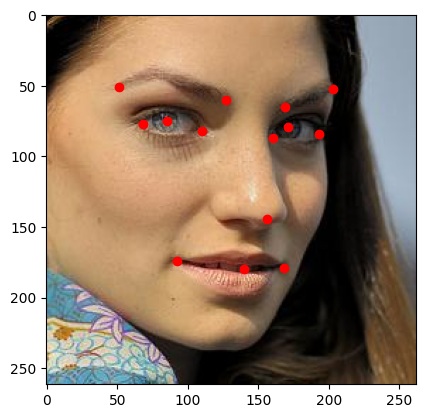

Shape (355, 355, 3)


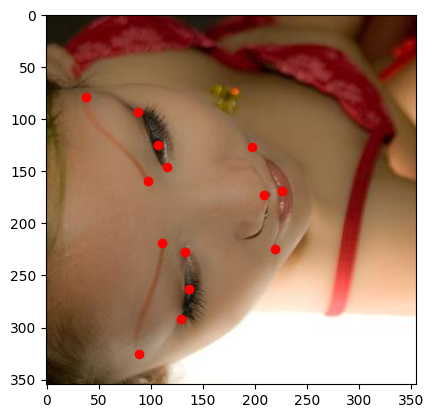

In [19]:
img = cv2.imread('tests/00_test_img_input/train/images/00000.jpg')[..., ::-1]
print('Shape', img.shape)

plt.imshow(img)
xx, yy = gt['00000.jpg'][::2], gt['00000.jpg'][1::2]
plt.scatter(x=xx, y=yy, c='r')
plt.show()

img = cv2.imread('tests/00_test_img_input/train/images/00010.jpg')[..., ::-1]
print('Shape', img.shape)

plt.imshow(img)
xx, yy = gt['00010.jpg'][::2], gt['00010.jpg'][1::2]
plt.scatter(x=xx, y=yy, c='r')
plt.show()

In [20]:
def print_imgs_info(path):
    files = sorted(os.listdir(path))
    shapes = [cv2.imread(f'{path}{p}').shape for p in files]
    sizes = [s[0] for s in shapes]
    channels = [s[2] for s in shapes]

    print('Sizes (min/mean/max):', min(sizes), int(np.mean(sizes)), max(sizes))
    print('Channels:', Counter(channels))

In [10]:
print_imgs_info('tests/00_test_img_input/train/images/')

Sizes (min/mean/max): 34 284 4340
Channels: Counter({3: 6000})


In [11]:
print_imgs_info('tests/00_test_img_input/test/images/')

Sizes (min/mean/max): 34 284 4340
Channels: Counter({3: 6000})


В выборках train и test статистические характеристики совпадают для данной задачи

## Dataset

In [12]:
class MyCustomDataset(Dataset):
    def __init__(
        self,
        mode,
        data_dir,
        fraction: float = 0.85,
        transform=None,
        train_gt=None
    ):
        self._items = []
        self._labels = []
        self._transform = transform

        image_files = os.listdir(data_dir)
        split_idx = int(fraction * len(image_files))

        if train_gt is None:
            train_gt = self._read_csv_to_dict('./tests/00_test_img_input/train/gt.csv')

        if mode == "train":
            selected_files = image_files[-split_idx:]
        elif mode == "val":
            selected_files = image_files[:-split_idx]

        for img_file in selected_files:
            img_path = os.path.join(data_dir, img_file)
            points = train_gt[img_file]
            if min(points) >= 0:
                self._items.append(img_path)
                self._labels.append(points)


    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img_path, labels = self._items[index], self._labels[index]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)
        labels = labels.reshape(-1, 2)

        if self._transform:
            transformed = self._transform(image=image, keypoints=labels)
            if len(transformed['keypoints']) == 14:
                image = transformed['image']
                labels = transformed['keypoints']

        image = np.array(image).astype(np.float32)
        image, labels = self._norm_image(image, labels)

        return image, labels

    @staticmethod
    def _read_csv_to_dict(csv_file):
        df = pd.read_csv(csv_file)
        result = {
            row['filename']: np.array(row[1:].values, dtype=np.float32) for _, row in df.iterrows()
        }
        return result

    @staticmethod
    def _norm_image(image, labels):
        res_image = A.Compose(
                [
                    A.Resize(284, 284),
                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                    ToTensorV2(),
                ]
              )(image=image)['image']
        labels = torch.tensor(labels, dtype=torch.float32).reshape(-1)
        labels[0::2] *= 284 / image.shape[1]
        labels[1::2] *= 284 / image.shape[0]
        return res_image, labels

## Model

In [13]:
class FaceModel(pl.LightningModule):
    def __init__(self, class_count=28):
        super().__init__()

        self.norm0 = nn.BatchNorm2d(3)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu1 = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 64, 3, padding = 'same')
        self.relu2 = nn.LeakyReLU(0.1)
        self.norm2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 3, padding = 'same')
        self.relu3 = nn.LeakyReLU(0.1)
        self.norm3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 3, padding = 'same')
        self.relu4 = nn.LeakyReLU(0.1)
        self.norm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv5 = nn.Conv2d(128, 128, 3, padding = 'same')
        self.relu5 = nn.LeakyReLU(0.1)
        self.norm5 = nn.BatchNorm2d(128)

        self.conv6 = nn.Conv2d(128, 128, 3, padding = 'same')
        self.relu6 = nn.LeakyReLU(0.1)
        self.norm6 = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128, 256, 3, padding = 'same')
        self.relu7 = nn.LeakyReLU(0.1)
        self.norm7 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv8 = nn.Conv2d(256, 256, 3, padding = 'same')
        self.relu8 = nn.LeakyReLU(0.1)
        self.norm8 = nn.BatchNorm2d(256)

        self.conv9 = nn.Conv2d(256, 256, 3, padding = 'same')
        self.relu9 = nn.LeakyReLU(0.1)
        self.norm9 = nn.BatchNorm2d(256)

        self.conv10 = nn.Conv2d(256, 512, 3, padding = 'same')
        self.relu10 = nn.LeakyReLU(0.1)
        self.norm10 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.conv11 = nn.Conv2d(512, 512, 3, padding = 'same')
        self.relu11 = nn.LeakyReLU(0.1)
        self.norm11 = nn.BatchNorm2d(512)

        self.conv12 = nn.Conv2d(512, 512, 3, padding = 'same')
        self.relu12 = nn.LeakyReLU(0.1)
        self.norm12 = nn.BatchNorm2d(512)

        self.conv13 = nn.Conv2d(512, 1024, 3, padding = 'same')
        self.relu13 = nn.LeakyReLU(0.1)
        self.norm13 = nn.BatchNorm2d(1024)
        self.pool5 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.LazyLinear(class_count)
        self.relu14 = nn.ReLU()

        self.loss = F.mse_loss

    def forward(self, x):

        x =  self.norm0(x)

        x = self.pool1(self.norm1(self.relu1(self.conv1(x))))

        x = x + self.norm3(self.relu3(self.conv3(self.norm2(self.relu2(self.conv2(x))))))
        x = self.pool2(self.norm4(self.relu4(self.conv4(x))))

        x = x + self.norm6(self.relu6(self.conv6(self.norm5(self.relu5(self.conv5(x))))))
        x = self.pool3(self.norm7(self.relu7(self.conv7(x))))

        x = x + self.norm9(self.relu9(self.conv9(self.norm8(self.relu8(self.conv8(x))))))
        x = self.pool4(self.norm10(self.relu10(self.conv10(x))))

        x = x + self.norm12(self.relu12(self.conv12(self.norm11(self.relu11(self.conv11(x))))))
        x = self.pool5(self.norm13(self.relu13(self.conv13(x))))

        x = self.relu14(self.fc1(self.flatten(x)))

        return x


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        metrics = { "train_loss": loss}
        self.log_dict(metrics, prog_bar=True, on_step=True, on_epoch=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=1e-3, weight_decay=5e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                                  mode='min',
                                                                  factor=0.5,
                                                                  patience=10,
                                                                  verbose=True)
        lr_dict = {
            "scheduler": lr_scheduler,
            "interval": "epoch",
            "frequency": 1,
            "monitor": "val_loss"
        }
        return [optimizer], [lr_dict]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        metrics = {"val_loss": loss}
        self.log_dict(metrics, prog_bar=True, on_step=True, on_epoch=True, logger=True)

        return metrics

## train_detector

In [4]:
def train_detector(train_gt, train_img_dir, fast_train=True):

    MyTransform = A.Compose(
        [A.Rotate(limit=40, p = 0.5),
        A.OneOf([
            A.RGBShift(r_shift_limit=[0, 100], g_shift_limit=[0,100], b_shift_limit=[0,100], p = 0.3),
            A.ToGray(p = 0.5)
        ]),
        A.MotionBlur(p = 0.3),
        ],keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

    if fast_train:
        batch_size = 2
    else:
        batch_size = 64

    ds_train = MyCustomDataset(mode="train", train_gt=train_gt, data_dir=train_img_dir, transform=MyTransform)
    ds_val = MyCustomDataset(mode="val", train_gt=train_gt, data_dir=train_img_dir)

    dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
    dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2)

    model = FaceModel()

    if fast_train:
        trainer = pl.Trainer(max_epochs=1,
                             max_steps=16,
                             accelerator='cpu',
                             devices=1,
                             logger=False,
                             callbacks = None,
                             enable_checkpointing=False)
        trainer.fit(model, dl_train, dl_val)
    else:
        MyTrainingModuleCheckpoint = ModelCheckpoint(dirpath="runs",
                                                     filename="{epoch}{val_loss:.2f}",
                                                     monitor="val_loss",
                                                     mode="min",
                                                     save_top_k=1,
                                                     )
        MyEarlyStopping = EarlyStopping(monitor="val_loss", mode="min", patience=50, verbose=True)

        trainer = pl.Trainer(
            max_epochs=110,
            accelerator="gpu",
            devices=1,
            callbacks=[MyEarlyStopping, MyTrainingModuleCheckpoint],
            log_every_n_steps=5,

            )

        trainer.fit(model, dl_train, dl_val)
        torch.save(model.to('cpu').state_dict(), "facepoints_model.ckpt")


    return model

## Train

In [2]:
model = train_detector(train_gt=None,
                       train_img_dir='./tests/00_test_img_input/train/images',
                       fast_train=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params | Mode 
-------------------------------------------------
0  | norm0   | BatchNorm2d | 6      | train
1  | conv1   | Conv2d      | 9.4 K  | train
2  | norm1   | BatchNorm2d | 128    | train
3  | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/module.py:512: You called `self.log('val_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=16` reached.


In [11]:
model = train_detector(train_gt=None,
                       train_img_dir='./tests/00_test_img_input/train/images',
                       fast_train=False)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/runs exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name    | Type        | Params | Mode 
-------------------------------------------------
0  | norm0   | BatchNorm2d | 6      | train
1  | conv1   | Conv2d      | 9.4 K  | train
2  | norm1   | BatchNorm2d | 128    | train
3  | relu1   | LeakyReLU   | 0      | train
4  | pool1   | MaxPool2d   | 0      | train
5  | conv2   | Conv2d      | 36.9 K | train
6  | relu2   | LeakyReLU   | 0      | train
7  | norm2   | BatchNorm2d | 128    | train
8  | conv3   | Conv2d    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

0: val_loss=18691.11328125


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 170.931


0: val_loss=170.93092346191406
0: train_loss=1382.5743408203125


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 46.561 >= min_delta = 0.0. New best score: 124.370


1: val_loss=124.3699951171875
1: train_loss=176.5853271484375


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 11.944 >= min_delta = 0.0. New best score: 112.426


2: val_loss=112.42639923095703
2: train_loss=140.7248992919922


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 6.967 >= min_delta = 0.0. New best score: 105.460


3: val_loss=105.45980072021484
3: train_loss=121.95115661621094


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 7.742 >= min_delta = 0.0. New best score: 97.717


4: val_loss=97.71736907958984
4: train_loss=105.02152252197266


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 7.050 >= min_delta = 0.0. New best score: 90.667


5: val_loss=90.6673355102539
5: train_loss=95.59117889404297


Validation: |          | 0/? [00:00<?, ?it/s]

6: val_loss=93.07203674316406
6: train_loss=87.6817855834961


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 10.008 >= min_delta = 0.0. New best score: 80.660


7: val_loss=80.65973663330078
7: train_loss=82.76490783691406


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 7.420 >= min_delta = 0.0. New best score: 73.240


8: val_loss=73.2401351928711
8: train_loss=68.30615234375


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.383 >= min_delta = 0.0. New best score: 68.857


9: val_loss=68.85739135742188
9: train_loss=69.0465087890625


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.911 >= min_delta = 0.0. New best score: 67.946


10: val_loss=67.94620513916016
10: train_loss=60.73201370239258


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 7.860 >= min_delta = 0.0. New best score: 60.086


11: val_loss=60.08582305908203
11: train_loss=60.50941467285156


Validation: |          | 0/? [00:00<?, ?it/s]

12: val_loss=70.06800842285156
12: train_loss=54.36499786376953


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.645 >= min_delta = 0.0. New best score: 57.441


13: val_loss=57.440650939941406
13: train_loss=50.1253662109375


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 3.987 >= min_delta = 0.0. New best score: 53.453


14: val_loss=53.453407287597656
14: train_loss=45.24612808227539


Validation: |          | 0/? [00:00<?, ?it/s]

15: val_loss=53.72229766845703
15: train_loss=49.613624572753906


Validation: |          | 0/? [00:00<?, ?it/s]

16: val_loss=56.38218307495117
16: train_loss=43.74501037597656


Validation: |          | 0/? [00:00<?, ?it/s]

17: val_loss=59.569190979003906
17: train_loss=43.27387619018555


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 4.464 >= min_delta = 0.0. New best score: 48.990


18: val_loss=48.98982238769531
18: train_loss=41.76534652709961


Validation: |          | 0/? [00:00<?, ?it/s]

19: val_loss=51.24545669555664
19: train_loss=39.1248664855957


Validation: |          | 0/? [00:00<?, ?it/s]

20: val_loss=50.21786117553711
20: train_loss=39.44942092895508


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 2.644 >= min_delta = 0.0. New best score: 46.346


21: val_loss=46.346004486083984
21: train_loss=40.24859619140625


Validation: |          | 0/? [00:00<?, ?it/s]

22: val_loss=55.6411247253418
22: train_loss=37.84290313720703


Validation: |          | 0/? [00:00<?, ?it/s]

23: val_loss=73.0712661743164
23: train_loss=37.346736907958984


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.688 >= min_delta = 0.0. New best score: 44.658


24: val_loss=44.65768814086914
24: train_loss=36.21260452270508


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.835 >= min_delta = 0.0. New best score: 43.823


25: val_loss=43.82312774658203
25: train_loss=36.32013702392578


Validation: |          | 0/? [00:00<?, ?it/s]

26: val_loss=47.97602462768555
26: train_loss=35.28633499145508


Validation: |          | 0/? [00:00<?, ?it/s]

27: val_loss=44.51289367675781
27: train_loss=33.638057708740234


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.640 >= min_delta = 0.0. New best score: 42.183


28: val_loss=42.18290710449219
28: train_loss=32.4261474609375


Validation: |          | 0/? [00:00<?, ?it/s]

29: val_loss=51.722408294677734
29: train_loss=31.36543846130371


Validation: |          | 0/? [00:00<?, ?it/s]

30: val_loss=42.60909652709961
30: train_loss=32.46394348144531


Validation: |          | 0/? [00:00<?, ?it/s]

31: val_loss=43.27112579345703
31: train_loss=33.71193313598633


Validation: |          | 0/? [00:00<?, ?it/s]

32: val_loss=47.67558670043945
32: train_loss=33.38285827636719


Validation: |          | 0/? [00:00<?, ?it/s]

33: val_loss=44.27592849731445
33: train_loss=31.794471740722656


Validation: |          | 0/? [00:00<?, ?it/s]

34: val_loss=44.29471969604492
34: train_loss=30.997604370117188


Validation: |          | 0/? [00:00<?, ?it/s]

35: val_loss=46.466007232666016
35: train_loss=30.076549530029297


Validation: |          | 0/? [00:00<?, ?it/s]

36: val_loss=43.168636322021484
36: train_loss=31.792680740356445


Validation: |          | 0/? [00:00<?, ?it/s]

37: val_loss=45.80464553833008
37: train_loss=29.252168655395508


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.201 >= min_delta = 0.0. New best score: 41.982


38: val_loss=41.98163604736328
38: train_loss=30.21761703491211


Validation: |          | 0/? [00:00<?, ?it/s]

39: val_loss=53.794639587402344
39: train_loss=32.014892578125


Validation: |          | 0/? [00:00<?, ?it/s]

40: val_loss=42.87957000732422
40: train_loss=31.335819244384766


Validation: |          | 0/? [00:00<?, ?it/s]

41: val_loss=48.73573684692383
41: train_loss=29.286882400512695


Validation: |          | 0/? [00:00<?, ?it/s]

42: val_loss=44.93609619140625
42: train_loss=30.318649291992188


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.798 >= min_delta = 0.0. New best score: 41.183


43: val_loss=41.18327331542969
43: train_loss=27.38288116455078


Validation: |          | 0/? [00:00<?, ?it/s]

44: val_loss=46.022911071777344
44: train_loss=27.4398193359375


Validation: |          | 0/? [00:00<?, ?it/s]

45: val_loss=43.53926086425781
45: train_loss=27.16892433166504


Validation: |          | 0/? [00:00<?, ?it/s]

46: val_loss=42.345394134521484
46: train_loss=26.50823974609375


Validation: |          | 0/? [00:00<?, ?it/s]

47: val_loss=41.53982162475586
47: train_loss=26.459312438964844


Validation: |          | 0/? [00:00<?, ?it/s]

48: val_loss=42.051185607910156
48: train_loss=27.203161239624023


Validation: |          | 0/? [00:00<?, ?it/s]

49: val_loss=42.54639434814453
49: train_loss=25.778234481811523


Validation: |          | 0/? [00:00<?, ?it/s]

50: val_loss=47.48775100708008
50: train_loss=24.746292114257812


Validation: |          | 0/? [00:00<?, ?it/s]

51: val_loss=45.28479766845703
51: train_loss=28.4152889251709


Validation: |          | 0/? [00:00<?, ?it/s]

52: val_loss=43.92817687988281
52: train_loss=25.123462677001953


Validation: |          | 0/? [00:00<?, ?it/s]

53: val_loss=43.76675033569336
53: train_loss=25.070552825927734


Validation: |          | 0/? [00:00<?, ?it/s]

54: val_loss=43.58742904663086
54: train_loss=24.263282775878906


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.916 >= min_delta = 0.0. New best score: 40.267


55: val_loss=40.26694107055664
55: train_loss=21.68157196044922


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 1.168 >= min_delta = 0.0. New best score: 39.099


56: val_loss=39.098609924316406
56: train_loss=19.457704544067383


Validation: |          | 0/? [00:00<?, ?it/s]

57: val_loss=40.382896423339844
57: train_loss=19.34620475769043


Validation: |          | 0/? [00:00<?, ?it/s]

58: val_loss=40.52793884277344
58: train_loss=18.8559513092041


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.429 >= min_delta = 0.0. New best score: 38.670


59: val_loss=38.6696891784668
59: train_loss=19.406461715698242


Validation: |          | 0/? [00:00<?, ?it/s]

60: val_loss=41.04681396484375
60: train_loss=18.69659423828125


Validation: |          | 0/? [00:00<?, ?it/s]

61: val_loss=39.030609130859375
61: train_loss=18.21211051940918


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.252 >= min_delta = 0.0. New best score: 38.417


62: val_loss=38.41719436645508
62: train_loss=17.93136215209961


Validation: |          | 0/? [00:00<?, ?it/s]

63: val_loss=39.1370849609375
63: train_loss=17.572765350341797


Validation: |          | 0/? [00:00<?, ?it/s]

64: val_loss=39.84727096557617
64: train_loss=17.46235466003418


Validation: |          | 0/? [00:00<?, ?it/s]

65: val_loss=40.9437370300293
65: train_loss=18.144575119018555


Validation: |          | 0/? [00:00<?, ?it/s]

66: val_loss=40.68204116821289
66: train_loss=18.400728225708008


Validation: |          | 0/? [00:00<?, ?it/s]

67: val_loss=38.50334930419922
67: train_loss=17.196876525878906


Validation: |          | 0/? [00:00<?, ?it/s]

68: val_loss=39.49763488769531
68: train_loss=17.070728302001953


Validation: |          | 0/? [00:00<?, ?it/s]

69: val_loss=39.5673942565918
69: train_loss=17.141376495361328


Validation: |          | 0/? [00:00<?, ?it/s]

70: val_loss=40.824649810791016
70: train_loss=16.58191680908203


Validation: |          | 0/? [00:00<?, ?it/s]

71: val_loss=41.16569519042969
71: train_loss=16.18310546875


Validation: |          | 0/? [00:00<?, ?it/s]

72: val_loss=40.566810607910156
72: train_loss=16.45943260192871


Validation: |          | 0/? [00:00<?, ?it/s]

73: val_loss=40.1175422668457
73: train_loss=17.033592224121094


Validation: |          | 0/? [00:00<?, ?it/s]

74: val_loss=38.83399200439453
74: train_loss=15.129443168640137


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.646 >= min_delta = 0.0. New best score: 37.771


75: val_loss=37.77073287963867
75: train_loss=14.686100959777832


Validation: |          | 0/? [00:00<?, ?it/s]

76: val_loss=38.669960021972656
76: train_loss=14.1073637008667


Validation: |          | 0/? [00:00<?, ?it/s]

77: val_loss=38.929847717285156
77: train_loss=13.916845321655273


Validation: |          | 0/? [00:00<?, ?it/s]

78: val_loss=39.16951370239258
78: train_loss=13.805094718933105


Validation: |          | 0/? [00:00<?, ?it/s]

79: val_loss=39.330753326416016
79: train_loss=13.539298057556152


Validation: |          | 0/? [00:00<?, ?it/s]

80: val_loss=38.889862060546875
80: train_loss=13.326589584350586


Validation: |          | 0/? [00:00<?, ?it/s]

81: val_loss=39.241302490234375
81: train_loss=13.686532974243164


Validation: |          | 0/? [00:00<?, ?it/s]

82: val_loss=39.35474395751953
82: train_loss=13.56113338470459


Validation: |          | 0/? [00:00<?, ?it/s]

83: val_loss=39.12171173095703
83: train_loss=13.319443702697754


Validation: |          | 0/? [00:00<?, ?it/s]

84: val_loss=39.603233337402344
84: train_loss=13.142387390136719


Validation: |          | 0/? [00:00<?, ?it/s]

85: val_loss=40.462154388427734
85: train_loss=13.395992279052734


INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

## Inference & results

In [12]:
def detect(model_path, test_img_dir):
    model_test = FaceModel.load_from_checkpoint(checkpoint_path=model_path)
    model_test.to('cpu')
    model_test.eval()
    imgs_names = os.listdir(test_img_dir)
    predictions = {}

    for filename in imgs_names:
        image = Image.open(os.path.join(test_img_dir, filename)).convert("RGB")
        image = np.array(image)
        normolize = A.Compose(
            [
                A.Resize(284, 284),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )
        norm_image = normolize(image=image)['image']

        pred = model_test(norm_image[None, ...].to('cpu')).reshape(-1)
        pred[0::2] *= image.shape[0] / 284
        pred[1::2] *= image.shape[1] / 284
        predictions[filename] = np.round(np.array(pred.detach().cpu().numpy()))
    return predictions

In [13]:
%%time
preds = detect(model_path='/content/facepoints_model.pt',
               test_img_dir='tests/00_test_img_input/test/images')

CPU times: user 13min 17s, sys: 35.6 s, total: 13min 52s
Wall time: 13min 58s


In [21]:
from numpy import array


detected_points = dict(sorted(preds.items()))
shapes_gt = read_csv("./tests/00_test_img_gt/img_shapes.csv")
mse_loss = {}
mean_loss = 0
for filename in detected_points:
    diff = (detected_points[filename] - gt[filename])
    diff[1::2] *= 100 / shapes_gt[filename][0]
    diff[::2] *= 100 / shapes_gt[filename][1]
    mean_loss += np.mean(diff**2)
    mse_loss[filename] = np.mean(diff**2)
mean_loss /= len(detected_points)
mse_loss = sorted(mse_loss.items(), key=lambda x:-x[1])
print(mean_loss)

3.9828991859226845


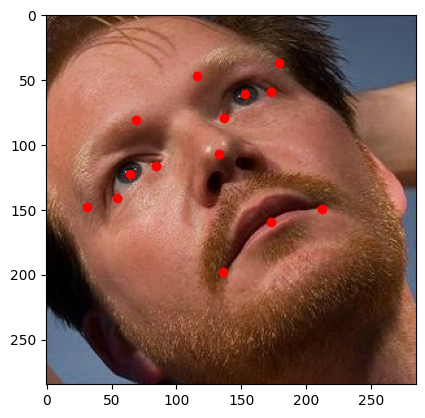

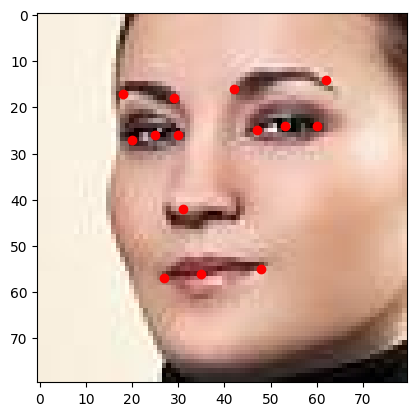

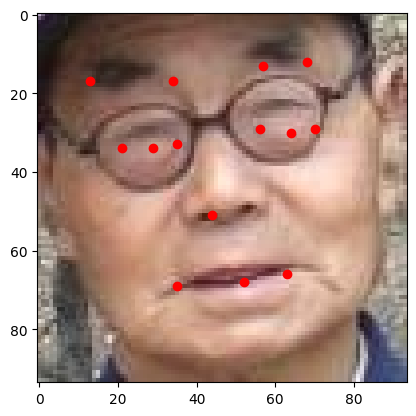

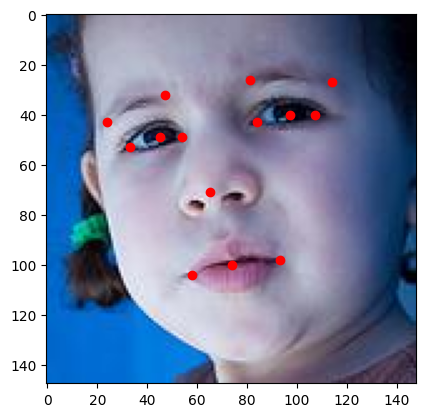

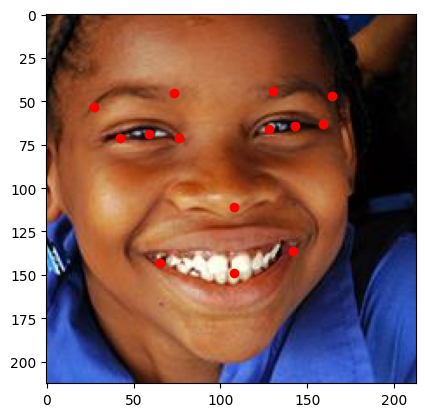

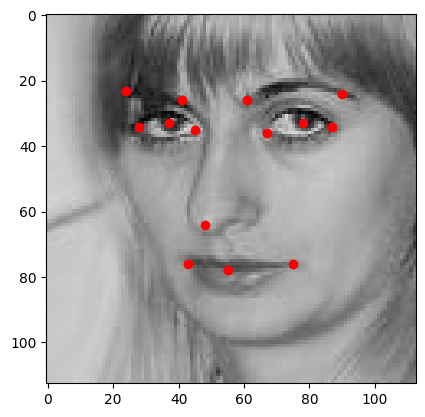

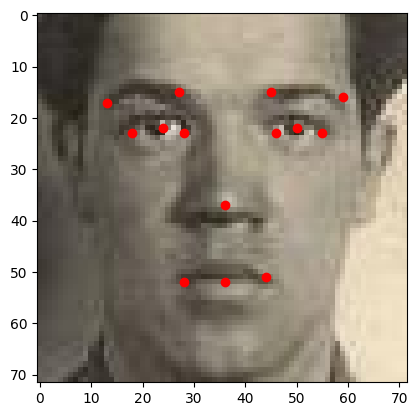

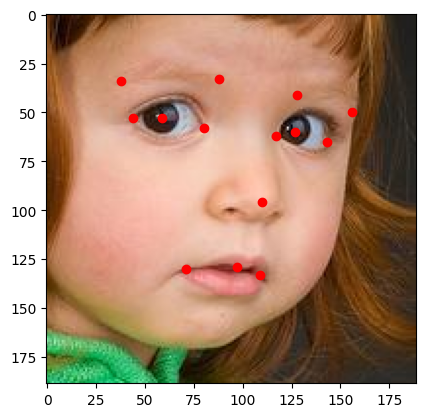

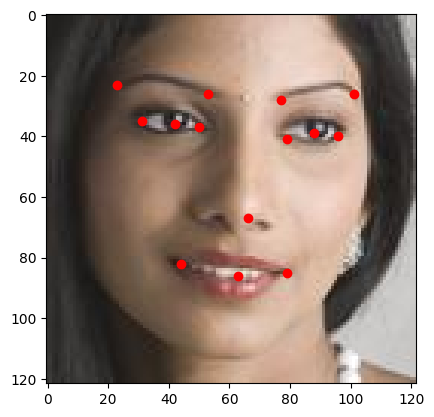

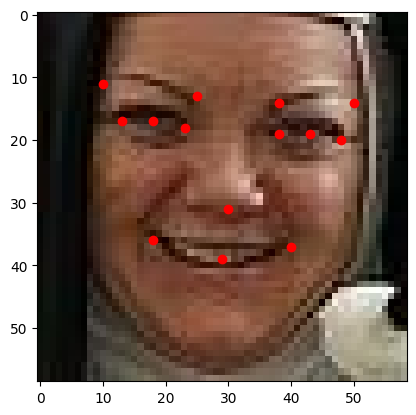

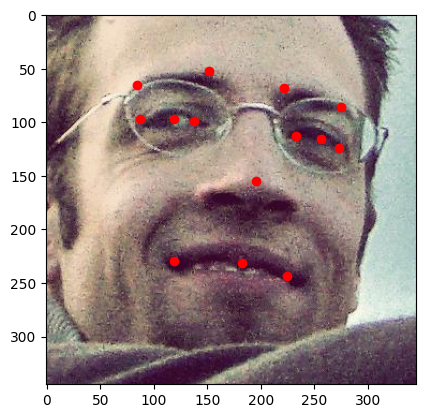

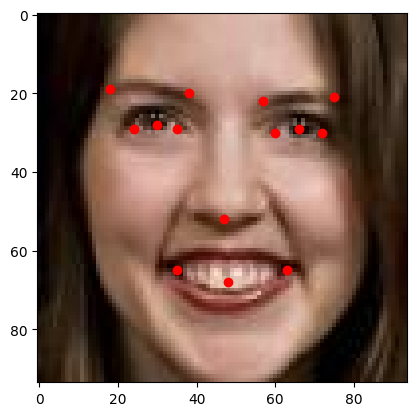

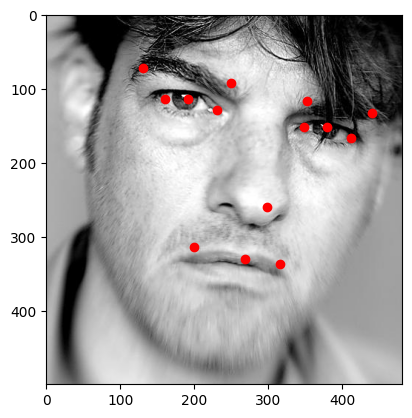

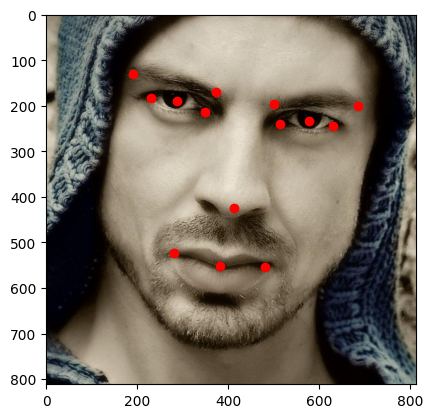

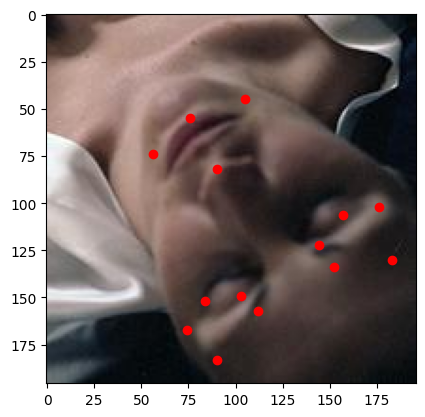

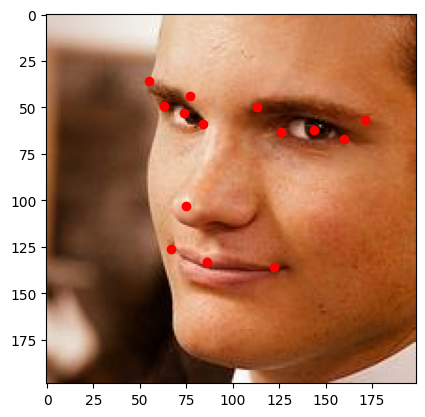

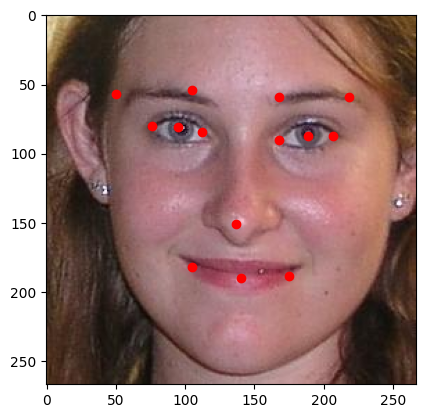

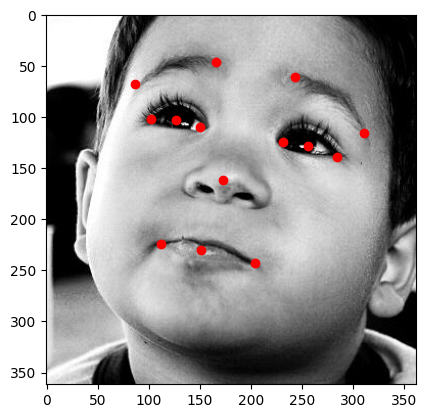

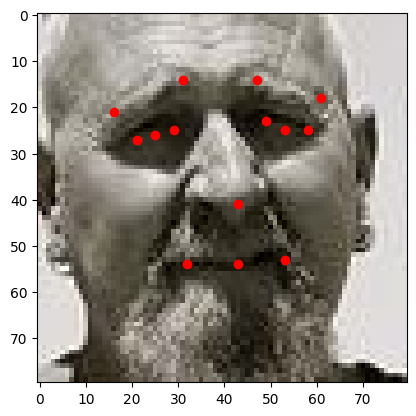

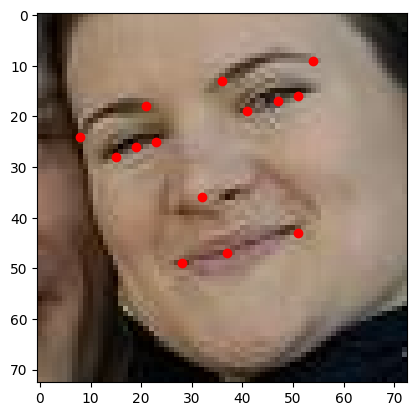

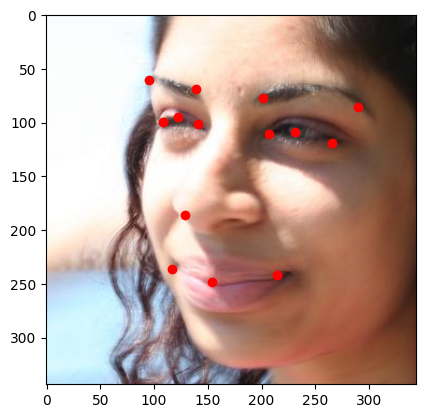

In [22]:
for i, (name, points) in enumerate(preds.items()):
    plt.imshow(Image.open(f'tests/00_test_img_input/test/images/{name}').convert('RGB'))
    xx, yy = points[::2], points[1::2]
    plt.scatter(x=xx, y=yy, c='r')
    plt.show()
    # time.sleep(2)
    if i == 20:
        break